<a href="https://colab.research.google.com/github/njauflo/Blightbuster/blob/main/potato2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Mount google drive to access dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [5]:
n_classes = 3
epochs = 10

train_path = '/content/drive/MyDrive/potato/train'
valid_path = '/content/drive/MyDrive/potato/valid'
test_path = '/content/drive/MyDrive/potato/test'


In [6]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

def build_model(n_classes):
  inputs = layers.Input(shape=(224,224,3))
  x = img_augmentation(inputs)

  model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

  model.trainable = False

#rebuild top
  x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
  x = layers.BatchNormalization()(x)

  top_dropout_rate = 0.2
  x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
  outputs = layers.Dense(n_classes, activation="softmax", name="pred")(x)

  model = tf.keras.Model(inputs, outputs, name="EfficientNet")
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
  model.compile(
      optimizer, loss="categorical_crossentropy",metrics=["accuracy"]
  )

  return model


In [7]:
def unfreeze_model(model):
    for layer in model.layers[-20:]:
      if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
        model.compile(
            optimizer,loss="categorical_crossentropy", metrics=["accuracy"]
        )

In [16]:
def test_model(model,test_ds):

    test_labels = test_ds.classes
    class_names = list(test_ds.class_indices.keys())
    print("Class names:", class_names)

    predictions = model.predict(test_ds, steps=len(test_ds), verbose=0)
    predicted_labels = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(test_labels, predicted_labels)
    print(f"Accuracy: {accuracy*100}%")

  # # Iterate over the images and labels in the first batch
  #   for images_batch, labels_batch in test_ds.take(1):
  #       first_image = images_batch[0].numpy().astype('uint8')

  #       predicted_probabilities = model.predict(np.expand_dims(first_image, axis=0))

  #       predicted_label = np.argmax(predicted_probabilities)

  #       actual_label = np.argmax(labels_batch[0])
  #       print(f"Actual label: {actual_label} Predicted label: {predicted_label}")

  #       plt.imshow(first_image)
  #       plt.title(f"actual label: {actual_label} Predicted label: {predicted_label}")
  #       plt.show()
  #       break
    cm = confusion_matrix(test_labels, predicted_labels)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicte label')
    plt.show()

    report = classification_report(test_labels, predicted_labels, target_names=class_names)
    print("Classification report:\n", report)

In [9]:
if __name__ == "__main__":

    model = build_model(n_classes)
    unfreeze_model(model)

    train_ds = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input).flow_from_directory(
        directory=train_path, target_size=(224,224), batch_size=10)
    valid_ds = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input).flow_from_directory(
        directory=valid_path, target_size=(224,224), batch_size=10)
    test_ds = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input).flow_from_directory(
        directory=test_path, target_size=(224,224), batch_size=1, shuffle=False)


    history = model.fit(train_ds, epochs=epochs, validation_data=valid_ds, verbose=1)


16705208/16705208 [==============================] - 0s 0us/step
Found 4656 images belonging to 3 classes.
Found 511 images belonging to 3 classes.
Found 405 images belonging to 3 classes.
Epoch 1/10
466/466 [==============================] - 784s 2s/step - loss: 0.3602 - accuracy: 0.8660 - val_loss: 0.1177 - val_accuracy: 0.9667
Epoch 2/10
466/466 [==============================] - 22s 47ms/step - loss: 0.1795 - accuracy: 0.9323 - val_loss: 0.1099 - val_accuracy: 0.9648
Epoch 3/10
466/466 [==============================] - 21s 45ms/step - loss: 0.1379 - accuracy: 0.9532 - val_loss: 0.1065 - val_accuracy: 0.9609
Epoch 4/10
466/466 [==============================] - 21s 44ms/step - loss: 0.1150 - accuracy: 0.9613 - val_loss: 0.0507 - val_accuracy: 0.9785
Epoch 5/10
466/466 [==============================] - 22s 48ms/step - loss: 0.1028 - accuracy: 0.9637 - val_loss: 0.0578 - val_accuracy: 0.9804
Epoch 6/10
466/466 [==============================] - 20s 43ms/step - loss: 0.0895 - accurac

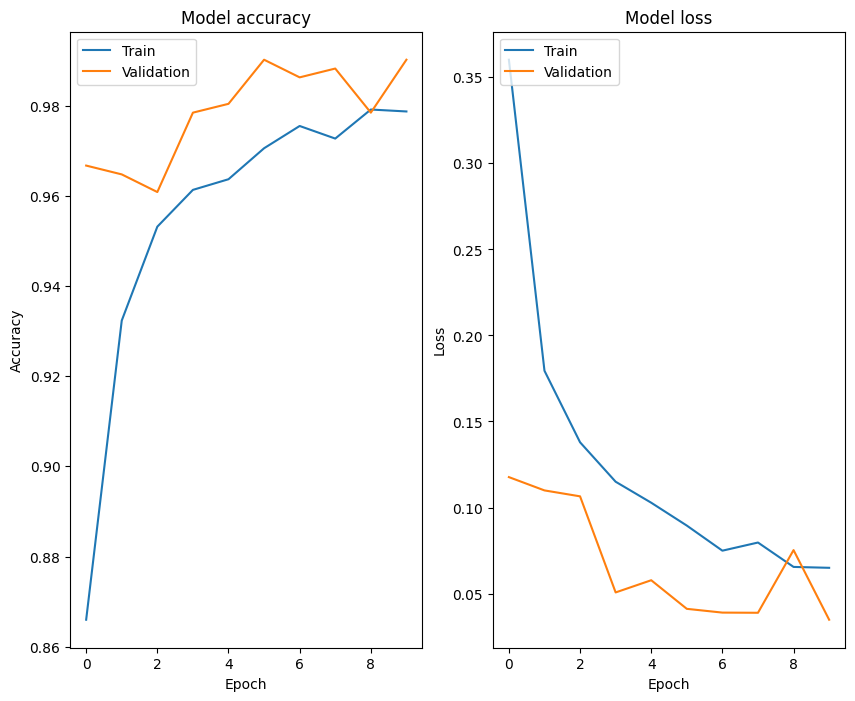

Class names: ['Early_Blight', 'Healthy', 'Late_Blight']
Accuracy: 98.51851851851852%


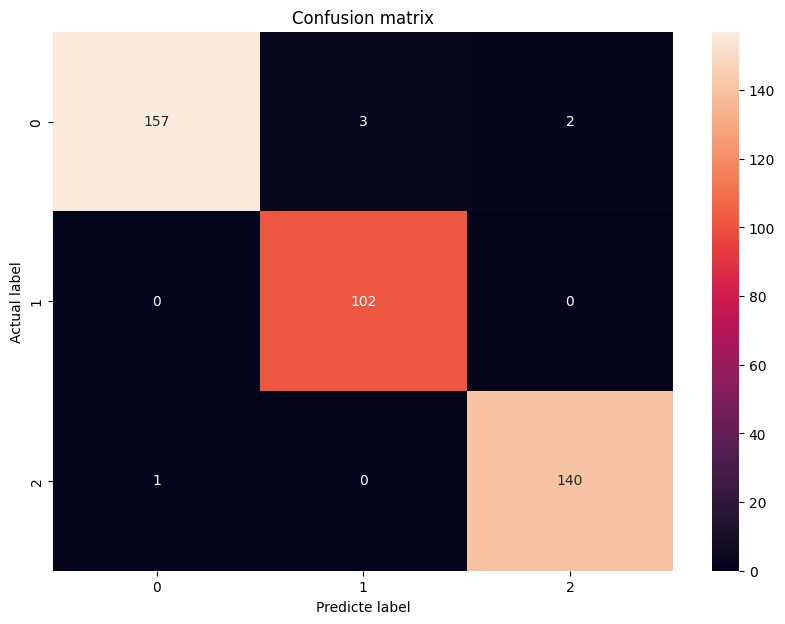

Classification report:
               precision    recall  f1-score   support

Early_Blight       0.99      0.97      0.98       162
     Healthy       0.97      1.00      0.99       102
 Late_Blight       0.99      0.99      0.99       141

    accuracy                           0.99       405
   macro avg       0.98      0.99      0.99       405
weighted avg       0.99      0.99      0.99       405



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

test_model(model, test_ds)

model.save('/content/drive/My Drive/efficientmodel.h5')